In [1]:
import nest_asyncio
nest_asyncio.apply()
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
import collections
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow import reshape, nest, config
from tensorflow.keras import losses, metrics, optimizers
import tensorflow_federated as tff
from matplotlib import pyplot as plt
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import reshape, nest, config
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Data Loading and Pre-Processing

In [2]:
np.random.seed(0)


experiment_name = "xray_image_dataset"
method = "tff_training"
this_dir = Path.cwd()
model_dir = this_dir / "models" 
output_dir = this_dir / "results" 


# Data generators
train_dir='./../Data/archive/Data/train/'
validation_dir='./../Data/archive/Data/test/'
batch_size=10

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen =  ImageDataGenerator(
      rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 32x32
        target_size=(32, 32),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode='categorical', color_mode = "grayscale")

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical', color_mode = "grayscale")


train_generator.class_indices.values()


# Store the data in X_train, y_train variables by iterating over the batches
train_generator.reset()
X_train, y_train = next(train_generator)
for i in tqdm(range(int(len(train_generator))-1)): 
    img, label = next(train_generator)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)


validation_generator.reset()
X_test, y_test = next(validation_generator)
for i in tqdm(range(int(len(validation_generator))-1)): 
    img, label = next(validation_generator)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)


Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.64it/s]


In [3]:

X_test = X_test.astype(np.float32)
y_test =  np.argmax(y_test, axis=-1).reshape([1288,1]).astype(np.int32)


X_train = X_train.astype(np.float32)
y_train =  np.argmax(y_train, axis=-1).reshape([5144,1]).astype(np.int32)


# Creating Federations

In [4]:
split=10 #Number of clients
total_image_count = len(X_train)
image_per_set = int(np.floor(total_image_count/split))


client_train_dataset = collections.OrderedDict()
for i in range(1, split+1):
    client_name = "client_" + str(i)
    start = image_per_set * (i-1)
    end = image_per_set * i

    print(f"Adding data from {start} to {end} for client : {client_name}")
    data = collections.OrderedDict((('label', y_train[start:end]), ('pixels', X_train[start:end])))
    client_train_dataset[client_name] = data



NUM_EPOCHS=10
BATCH_SIZE=10
PREFETCH_BUFFER = 10


train_dataset = tff.simulation.FromTensorSlicesClientData(client_train_dataset)

sample_dataset = train_dataset.create_tf_dataset_for_client(train_dataset.client_ids[0])

sample_element = next(iter(sample_dataset))

SHUFFLE_BUFFER = image_per_set

def preprocess(dataset):

    def batch_format_fn(element):
        """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
        return collections.OrderedDict(
            x=reshape(element['pixels'], [-1, 32, 32, 1]),
            y=reshape(element['label'], [-1, 1]))



    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
        BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)


preprocessed_sample_dataset = preprocess(sample_dataset)
sample_batch = nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_sample_dataset)))


def make_federated_data(client_data, client_ids):
    return [preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_ids]

federated_train_data = make_federated_data(train_dataset, train_dataset.client_ids)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Adding data from 0 to 514 for client : client_1
Adding data from 514 to 1028 for client : client_2
Adding data from 1028 to 1542 for client : client_3
Adding data from 1542 to 2056 for client : client_4
Adding data from 2056 to 2570 for client : client_5
Adding data from 2570 to 3084 for client : client_6
Adding data from 3084 to 3598 for client : client_7
Adding data from 3598 to 4112 for client : client_8
Adding data from 4112 to 4626 for client : client_9
Adding data from 4626 to 5140 for client : client_10
Number of client datasets: 10
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 32, 32, 1)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


# Model 1

In [5]:
np.random.seed(78)
#99

def model1():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(64, activation='relu'),
#         Dropout(0.3),
        Dense(3, activation='softmax')

    ])
    return model


method = "tff_training"
client_lr = 1e-3
server_lr = 1e-3
NUM_ROUNDS = 15


def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.

    keras_model = model1()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_sample_dataset.element_spec,
      loss=losses.SparseCategoricalCrossentropy(),
      metrics=[metrics.SparseCategoricalAccuracy()])


iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: optimizers.Adagrad(learning_rate=client_lr),
    server_optimizer_fn=lambda: optimizers.RMSprop(learning_rate=server_lr))

print(str(iterative_process.initialize.type_signature))

state = iterative_process.initialize()

tff_train_acc2 = []
tff_val_acc2 = []
tff_train_loss2 = []
tff_val_loss2 = []

eval_model1 = None
best_accuracy = 0
for round_num in range(1, NUM_ROUNDS+1):
    state, tff_metrics = iterative_process.next(state, federated_train_data)
    eval_model1 = model1()
    eval_model1.compile(optimizer=optimizers.Adam(learning_rate=client_lr),
                       loss=losses.SparseCategoricalCrossentropy(),
                       metrics=[metrics.SparseCategoricalAccuracy()])

    tff.learning.assign_weights_to_keras_model(eval_model1, state.model)

    ev_result1 = eval_model1.evaluate(X_test, y_test, verbose=0)
    print('round {:2d}, metrics={}'.format(round_num, tff_metrics))
    print(f"Validation loss : {ev_result1[0]} and Validation accuracy : {ev_result1[1]*100}")
    tff_train_acc2.append(float(tff_metrics.sparse_categorical_accuracy)*100)
    tff_val_acc2.append(ev_result1[1]*100)
    tff_train_loss2.append(float(tff_metrics.loss))
    tff_val_loss2.append(ev_result1[0])
    if ev_result1[1] > best_accuracy:
        eval_model1.save_weights('./checkpoints/my_checkpoint')
        best_accuracy = ev_result1[1]
        eval_model1.save("federated_best_model210.h5")

metric_collection = {"sparse_categorical_accuracy": tff_train_acc2,
                     "val_sparse_categorical_accuracy": tff_val_acc2,
                     "loss": tff_train_loss2,
                     "val_loss": tff_val_loss2}




Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
( -> <model=<trainable=<float32[3,3,1,32],float32[32],float32[3,3,32,64],float32[64],float32[2304,32],float32[32],float32[32,64],float32[64],float32[64,3],float32[3]>,non_trainable=<>>,optimizer_state=<int64,float32[3,3,1,32],float32[32],float32[3,3,32,64],float32[64],float32[2304,32],float32[32],float32[32,64],float32[64],float32[64,3],float32[3]>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)
round  1, metrics=<sparse_categorical_accuracy=0.6575291752815247,loss=0.8998731374740601,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.9373000082762345 and Validation accuracy : 66.38198494911194
round  2, metrics=<sparse_categorical_accuracy=0.6643968820571899,loss=0.8405947685241699,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.8475513465656257 and Validatio

## Evaluation

In [6]:
model2 = tf.keras.models.load_model('federated_best_model210.h5')

In [7]:
pred2 = model2.predict(X_test)

In [8]:
pred2 = np.argmax(pred2, axis=-1)

In [9]:
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.65      0.65      0.65       317
           2       0.79      0.89      0.84       855

    accuracy                           0.75      1288
   macro avg       0.48      0.52      0.50      1288
weighted avg       0.68      0.75      0.72      1288



c:\users\ushou\downloads\data science and ai\msc project\federated\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\ushou\downloads\data science and ai\msc project\federated\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\ushou\downloads\data science and ai\msc project\federated\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

<AxesSubplot:>

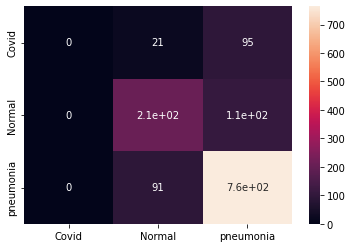

In [10]:
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot = True, xticklabels=["Covid", "Normal", "pneumonia"], yticklabels=["Covid", "Normal", "pneumonia"])

## Plotting Results

In [11]:
def plot_graph(X, y, format = '-', label=''):
    plt.plot(X, y, format, label=label)
    plt.xlabel("Rounds")
    plt.ylabel("Value")
    plt.grid(True)

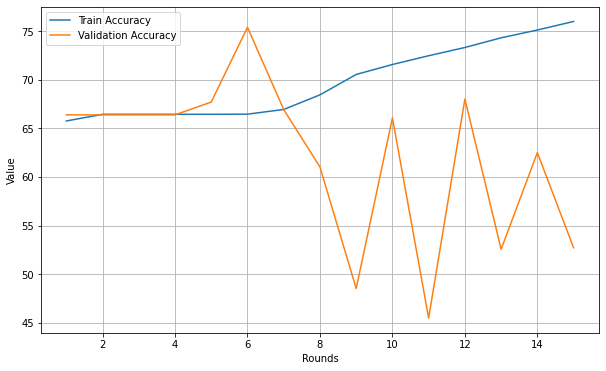

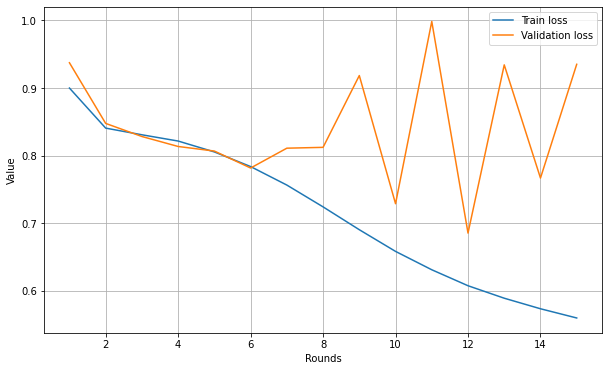

In [12]:
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_acc2, label='Train Accuracy')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_acc2, label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "federated_model210_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_loss2, label='Train loss')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_loss2, label='Validation loss')
plt.legend()
plt.savefig(output_dir / "federated_model210_loss.png")

## Saving Results

In [13]:
# saving metric values to text file

txt_file_path = output_dir / (experiment_name + ".txt")
with open(txt_file_path.as_posix(), "w") as handle:
    content = []
    for key, val in metric_collection.items():
        line_content = key
        val = [str(k) for k in val]
        line_content = line_content + " " + " ".join(val)
        content.append(line_content)
    handle.write("\n".join(content))

# Model 2

In [14]:
np.random.seed(99)
def model1():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
#         Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')

    ])
    return model


method = "tff_training"
client_lr = 1e-3
server_lr = 1e-3
NUM_ROUNDS = 15


def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.

    keras_model = model1()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_sample_dataset.element_spec,
      loss=losses.SparseCategoricalCrossentropy(),
      metrics=[metrics.SparseCategoricalAccuracy()])


iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: optimizers.Adagrad(learning_rate=client_lr),
    server_optimizer_fn=lambda: optimizers.RMSprop(learning_rate=server_lr))

print(str(iterative_process.initialize.type_signature))

state = iterative_process.initialize()

tff_train_acc1 = []
tff_val_acc1 = []
tff_train_loss1 = []
tff_val_loss1 = []

eval_model1 = None
best_accuracy = 0
for round_num in range(1, NUM_ROUNDS+1):
    state, tff_metrics = iterative_process.next(state, federated_train_data)
    eval_model1 = model1()
    eval_model1.compile(optimizer=optimizers.Adam(learning_rate=client_lr),
                       loss=losses.SparseCategoricalCrossentropy(),
                       metrics=[metrics.SparseCategoricalAccuracy()])

    tff.learning.assign_weights_to_keras_model(eval_model1, state.model)

    ev_result1 = eval_model1.evaluate(X_test, y_test, verbose=0)
    print('round {:2d}, metrics={}'.format(round_num, tff_metrics))
    print(f"Validation loss : {ev_result1[0]} and Validation accuracy : {ev_result1[1]*100}")
    tff_train_acc1.append(float(tff_metrics.sparse_categorical_accuracy)*100)
    tff_val_acc1.append(ev_result1[1]*100)
    tff_train_loss1.append(float(tff_metrics.loss))
    tff_val_loss1.append(ev_result1[0])
    if ev_result1[1] > best_accuracy:
        eval_model1.save_weights('./checkpoints/my_checkpoint')
        best_accuracy = ev_result1[1]
        eval_model1.save("federated_best_model110.h5")
        

metric_collection = {"sparse_categorical_accuracy": tff_train_acc1,
                     "val_sparse_categorical_accuracy": tff_val_acc1,
                     "loss": tff_train_loss1,
                     "val_loss": tff_val_loss1}

#if eval_model:
#    eval_model.save(model_dir / (experiment_name + ".h5"))
#else:
#    print("training didn't started")
#    exit()



( -> <model=<trainable=<float32[3,3,1,32],float32[32],float32[3,3,32,64],float32[64],float32[3,3,64,64],float32[64],float32[256,128],float32[128],float32[128,3],float32[3]>,non_trainable=<>>,optimizer_state=<int64,float32[3,3,1,32],float32[32],float32[3,3,32,64],float32[64],float32[3,3,64,64],float32[64],float32[256,128],float32[128],float32[128,3],float32[3]>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)
round  1, metrics=<sparse_categorical_accuracy=0.6503890752792358,loss=0.8846806883811951,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.8621813680814661 and Validation accuracy : 66.38198494911194
round  2, metrics=<sparse_categorical_accuracy=0.6618871688842773,loss=0.8492431640625,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.8287277821428287 and Validation accuracy : 66.38198494911194
round  3, metrics=<sparse_categorical_accuracy=0.6638715863227844,loss=0.8378345370292664,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.809709021

# Evaluation

In [15]:
eval_model1.load_weights('./checkpoints/my_checkpoint')

In [16]:
loaded_model = tf.keras.models.load_model('federated_best_model110.h5')

In [17]:
pred2 = loaded_model.predict(X_test)

In [18]:
pred2 = np.argmax(pred2, axis=-1)

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.61      0.87      0.72       317
           2       0.89      0.87      0.88       855

    accuracy                           0.79      1288
   macro avg       0.50      0.58      0.53      1288
weighted avg       0.74      0.79      0.76      1288



c:\users\ushou\downloads\data science and ai\msc project\federated\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\ushou\downloads\data science and ai\msc project\federated\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\ushou\downloads\data science and ai\msc project\federated\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

<AxesSubplot:>

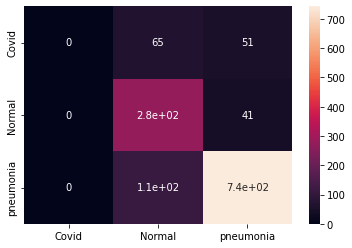

In [20]:
import seaborn as sns
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot = True, xticklabels=["Covid", "Normal", "pneumonia"], yticklabels=["Covid", "Normal", "pneumonia"])

# Plotting Results

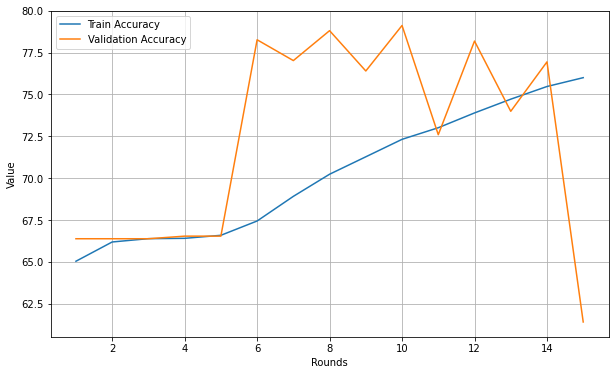

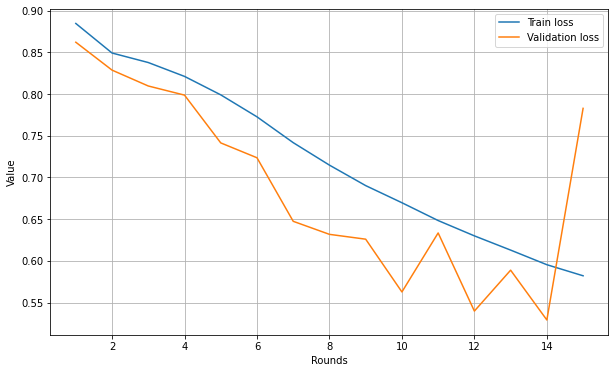

In [21]:
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_acc1, label='Train Accuracy')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_acc1, label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "federated_model110_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_loss1, label='Train loss')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_loss1, label='Validation loss')
plt.legend()
plt.savefig(output_dir / "federated_model110_loss.png")

# Model 3

In [22]:
np.random.seed(99)

def model1():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')

    ])
    return model



method = "tff_training"
client_lr = 1e-3
server_lr = 1e-3
NUM_ROUNDS = 15


def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.

    keras_model = model1()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_sample_dataset.element_spec,
      loss=losses.SparseCategoricalCrossentropy(),
      metrics=[metrics.SparseCategoricalAccuracy()])


iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: optimizers.Adagrad(learning_rate=client_lr),
    server_optimizer_fn=lambda: optimizers.RMSprop(learning_rate=server_lr))

print(str(iterative_process.initialize.type_signature))

state = iterative_process.initialize()

tff_train_acc3 = []
tff_val_acc3 = []
tff_train_loss3 = []
tff_val_loss3 = []

eval_model1 = None
best_accuracy = 0
for round_num in range(1, NUM_ROUNDS+1):
    state, tff_metrics = iterative_process.next(state, federated_train_data)
    eval_model1 = model1()
    eval_model1.compile(optimizer=optimizers.Adam(learning_rate=client_lr),
                       loss=losses.SparseCategoricalCrossentropy(),
                       metrics=[metrics.SparseCategoricalAccuracy()])

    tff.learning.assign_weights_to_keras_model(eval_model1, state.model)

    ev_result1 = eval_model1.evaluate(X_test, y_test, verbose=0)
    print('round {:2d}, metrics={}'.format(round_num, tff_metrics))
    print(f"Validation loss : {ev_result1[0]} and Validation accuracy : {ev_result1[1]*100}")
    tff_train_acc3.append(float(tff_metrics.sparse_categorical_accuracy)*100)
    tff_val_acc3.append(ev_result1[1]*100)
    tff_train_loss3.append(float(tff_metrics.loss))
    tff_val_loss3.append(ev_result1[0])
    if ev_result1[1] > best_accuracy:
        eval_model1.save_weights('./checkpoints/my_checkpoint')
        best_accuracy = ev_result1[1]
        eval_model1.save("federated_best_model310.h5")
        

metric_collection = {"sparse_categorical_accuracy": tff_train_acc3,
                     "val_sparse_categorical_accuracy": tff_val_acc3,
                     "loss": tff_train_loss3,
                     "val_loss": tff_val_loss3}




( -> <model=<trainable=<float32[3,3,1,32],float32[32],float32[7200,64],float32[64],float32[64,3],float32[3]>,non_trainable=<>>,optimizer_state=<int64,float32[3,3,1,32],float32[32],float32[7200,64],float32[64],float32[64,3],float32[3]>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)
round  1, metrics=<sparse_categorical_accuracy=0.6634824872016907,loss=0.8561319708824158,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.8352635728646509 and Validation accuracy : 66.38198494911194
round  2, metrics=<sparse_categorical_accuracy=0.6659338474273682,loss=0.7967105507850647,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.7740491798945835 and Validation accuracy : 74.30124282836914
round  3, metrics=<sparse_categorical_accuracy=0.6792412400245667,loss=0.7305594682693481,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.6683409376914456 and Validation accuracy : 73.6801266670227
round  4, metrics=<sparse_categorical_accuracy=0.6947081685066223,loss=0.6

# Evaluation

In [23]:
model3 = tf.keras.models.load_model('federated_best_model310.h5')

In [24]:
pred3 = model3.predict(X_test)

In [25]:
pred3 = np.argmax(pred3, axis=-1)

In [26]:
print(classification_report(y_test, pred3))

              precision    recall  f1-score   support

           0       0.97      0.25      0.40       116
           1       0.61      0.86      0.72       317
           2       0.87      0.83      0.85       855

    accuracy                           0.79      1288
   macro avg       0.82      0.65      0.65      1288
weighted avg       0.82      0.79      0.78      1288



<AxesSubplot:>

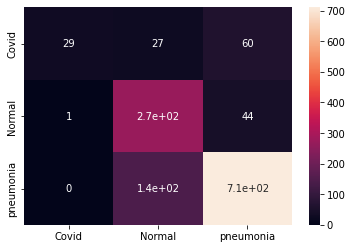

In [27]:
cm = confusion_matrix(y_test, pred3)
sns.heatmap(cm, annot = True, xticklabels=["Covid", "Normal", "pneumonia"], yticklabels=["Covid", "Normal", "pneumonia"])

# Plotting Results

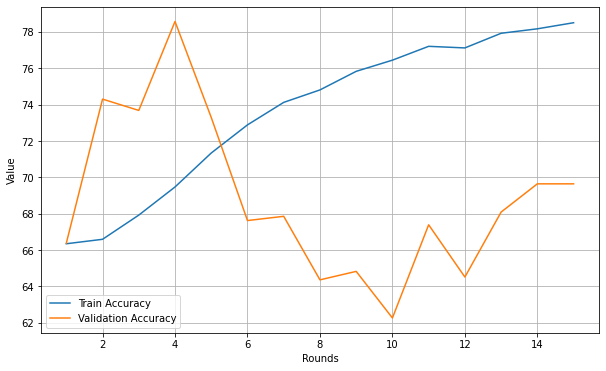

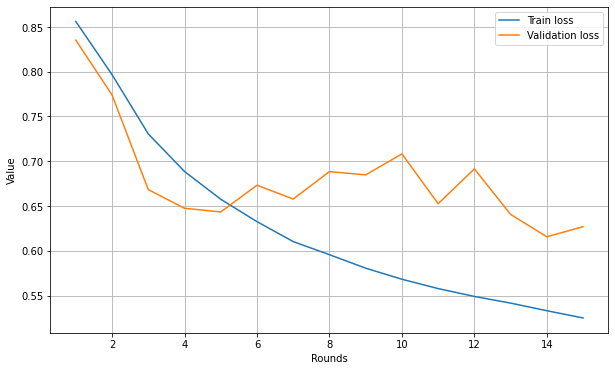

In [28]:
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_acc3, label='Train Accuracy')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_acc3, label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "federated_model310_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_loss3, label='Train loss')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_loss3, label='Validation loss')
plt.legend()
plt.savefig(output_dir / "federated_model310_loss.png")

# Model 4

In [29]:
np.random.seed(99)

def model1():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
#         Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')

    ])
    return model



method = "tff_training"
client_lr = 1e-3
server_lr = 1e-3
NUM_ROUNDS = 15


def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.

    keras_model = model1()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_sample_dataset.element_spec,
      loss=losses.SparseCategoricalCrossentropy(),
      metrics=[metrics.SparseCategoricalAccuracy()])


iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: optimizers.Adagrad(learning_rate=client_lr),
    server_optimizer_fn=lambda: optimizers.RMSprop(learning_rate=server_lr))

print(str(iterative_process.initialize.type_signature))

state = iterative_process.initialize()

tff_train_acc4 = []
tff_val_acc4 = []
tff_train_loss4 = []
tff_val_loss4 = []

eval_model1 = None
best_accuracy = 0
for round_num in range(1, NUM_ROUNDS+1):
    state, tff_metrics = iterative_process.next(state, federated_train_data)
    eval_model1 = model1()
    eval_model1.compile(optimizer=optimizers.Adam(learning_rate=client_lr),
                       loss=losses.SparseCategoricalCrossentropy(),
                       metrics=[metrics.SparseCategoricalAccuracy()])

    tff.learning.assign_weights_to_keras_model(eval_model1, state.model)

    ev_result1 = eval_model1.evaluate(X_test, y_test, verbose=0)
    print('round {:2d}, metrics={}'.format(round_num, tff_metrics))
    print(f"Validation loss : {ev_result1[0]} and Validation accuracy : {ev_result1[1]*100}")
    tff_train_acc4.append(float(tff_metrics.sparse_categorical_accuracy)*100)
    tff_val_acc4.append(ev_result1[1]*100)
    tff_train_loss4.append(float(tff_metrics.loss))
    tff_val_loss4.append(ev_result1[0])
    if ev_result1[1] > best_accuracy:
        eval_model1.save_weights('./checkpoints/my_checkpoint')
        best_accuracy = ev_result1[1]
        eval_model1.save("federated_best_model410.h5")
        

metric_collection = {"sparse_categorical_accuracy": tff_train_acc4,
                     "val_sparse_categorical_accuracy": tff_val_acc4,
                     "loss": tff_train_loss4,
                     "val_loss": tff_val_loss4}


( -> <model=<trainable=<float32[3,3,1,32],float32[32],float32[3,3,32,32],float32[32],float32[6272,512],float32[512],float32[512,3],float32[3]>,non_trainable=<>>,optimizer_state=<int64,float32[3,3,1,32],float32[32],float32[3,3,32,32],float32[32],float32[6272,512],float32[512],float32[512,3],float32[3]>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)
round  1, metrics=<sparse_categorical_accuracy=0.6565758585929871,loss=0.8350598216056824,keras_training_time_client_sum_sec=0.0>
Validation loss : 1.5754330469214397 and Validation accuracy : 66.38198494911194
round  2, metrics=<sparse_categorical_accuracy=0.6682490110397339,loss=0.7702046632766724,keras_training_time_client_sum_sec=0.0>
Validation loss : 2.857901016377514 and Validation accuracy : 15.062111616134644
round  3, metrics=<sparse_categorical_accuracy=0.6851361989974976,loss=0.7133948802947998,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.911935083614373 and Validation accuracy : 67.00310707092285
round 

# Evaluation

In [30]:
model4 = tf.keras.models.load_model('federated_best_model410.h5')

In [31]:
pred4 = model4.predict(X_test)

In [32]:
pred4 = np.argmax(pred4, axis=-1)

In [33]:
print(classification_report(y_test, pred4))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       116
           1       0.79      0.79      0.79       317
           2       0.92      0.91      0.92       855

    accuracy                           0.88      1288
   macro avg       0.84      0.87      0.86      1288
weighted avg       0.88      0.88      0.88      1288



<AxesSubplot:>

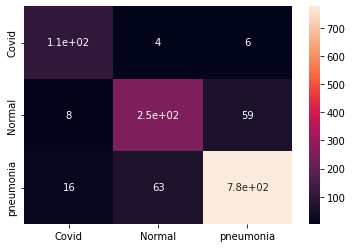

In [34]:
cm = confusion_matrix(y_test, pred4)
sns.heatmap(cm, annot = True, xticklabels=["Covid", "Normal", "pneumonia"], yticklabels=["Covid", "Normal", "pneumonia"])

# Plotting Results

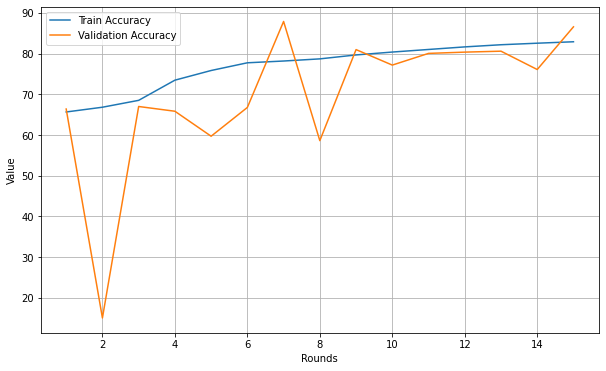

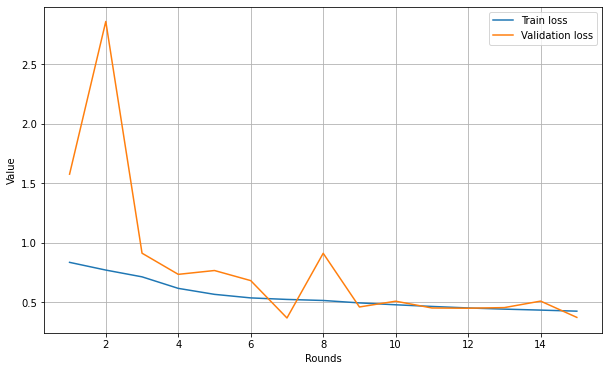

In [35]:
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_acc4, label='Train Accuracy')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_acc4, label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "federated_model410_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_loss4, label='Train loss')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_loss4, label='Validation loss')
plt.legend()
plt.savefig(output_dir / "federated_model410_loss.png")